<h1>This Notebook is Concerned With Scoring Boston Neighborhoods Using PCA</h1>
<p>The first third of this notebook deals with cleaning the scoring variables and creating the scoring dataset. The second third of this notebook deals with transforming rent, income, and home price variables to prepare them for PCA. The last third of this notebook deals with perfoming PCA in order to create a measure of gentrification for each Census Tract in Boston.</p>

In [ ]:
import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'
import os
import re
import glob
import numpy as np
from functools import reduce
import seaborn as sns

from sklearn import decomposition  
from sklearn.preprocessing import scale  
from sklearn import preprocessing 
from sklearn import linear_model
from sklearn import model_selection
#from sklearn import cross_validation

from scipy.stats import boxcox
from scipy.stats import spearmanr
from scipy.stats import pearsonr

# For reproducibility
import random
import numpy as np
r_state = 42
random.seed(r_state) 
np.random.seed(r_state)

# Needed on a Mac
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt 

<h2>Clean and Load the Scoring Data</h2> 
<p>We will have to clean and load the scoring data for education, occupation, income, median home value, and median contract rent.</p>

<h3>Cleaning the Education Data</h3>
<p>Education data is only available from the ACS by sex. Therefore final counts for each education level are the sum of the female and male counts.</p>

In [ ]:
edu2010 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2010/ACSDT5Y2010.B15002.csv")
edu2019 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2019/ACSDT5Y2019.B15002.csv")

def clean_acsEdu(acs_edu):
    
    acs_edu.drop(index = acs_edu.index[0], axis = 0, inplace = True)
    # strip GEO_ID of first 11 characters
    acs_edu.loc[:,'GEO_ID'] = acs_edu.loc[:, 'GEO_ID'].str[-11:]
    # drop NAME column
    acs_edu.drop("NAME", axis=1, inplace=True)
    # drop all margin of error columns
    acs_edu.drop(list(acs_edu.filter(regex = 'M')), axis = 1, inplace = True)
    # convert non-GEO_ID columns to numeric
    num_cols = acs_edu.columns.drop('GEO_ID')
    acs_edu[num_cols] = acs_edu[num_cols].apply(pd.to_numeric, errors='coerce')
    # drop all NA values
    #acs_edu.dropna(inplace= True)
    
    acs_edu.drop(['B15002_002E', 
                   'B15002_019E'], axis=1, inplace=True)
    acs_edu.rename(columns={'GEO_ID':'geoid',
                            'B15002_001E':'total (education)'}, inplace=True)
    
    acs_edu['noSchool'] = acs_edu['B15002_003E'] + acs_edu['B15002_020E']
    acs_edu.drop(['B15002_003E', 
              'B15002_020E'], axis=1, inplace=True)

    acs_edu['elementary'] = acs_edu['B15002_004E'] + acs_edu['B15002_005E'] + acs_edu['B15002_006E'] + acs_edu['B15002_021E'] + acs_edu['B15002_022E'] + acs_edu['B15002_023E']
    acs_edu.drop(['B15002_004E', 
                  'B15002_005E', 
                  'B15002_006E', 
                  'B15002_021E', 
                  'B15002_022E', 
                  'B15002_023E'], axis=1, inplace=True)

    acs_edu['middleSchool'] = acs_edu['B15002_007E'] + acs_edu['B15002_008E'] + acs_edu['B15002_009E'] + acs_edu['B15002_010E'] + acs_edu['B15002_024E'] + acs_edu['B15002_025E'] + acs_edu['B15002_026E'] + acs_edu['B15002_027E']
    acs_edu.drop(['B15002_007E', 
                  'B15002_008E', 
                  'B15002_009E', 
                  'B15002_010E', 
                  'B15002_024E', 
                  'B15002_025E', 
                  'B15002_026E', 
                  'B15002_027E'], axis=1, inplace=True)

    acs_edu['highSchool'] = acs_edu['B15002_011E'] + acs_edu['B15002_012E'] + acs_edu['B15002_013E'] + acs_edu['B15002_028E'] + acs_edu['B15002_029E'] + acs_edu['B15002_030E']
    acs_edu.drop(['B15002_011E', 
                  'B15002_012E', 
                  'B15002_013E', 
                  'B15002_028E', 
                  'B15002_029E', 
                  'B15002_030E'], axis=1, inplace=True)

    acs_edu['associates'] = acs_edu['B15002_014E'] + acs_edu['B15002_031E']
    acs_edu.drop(['B15002_014E', 
                  'B15002_031E'], axis=1, inplace=True)

    acs_edu['bachelors'] = acs_edu['B15002_015E'] + acs_edu['B15002_032E']
    acs_edu.drop(['B15002_015E', 
                  'B15002_032E'], axis=1, inplace=True)

    acs_edu['masters'] = acs_edu['B15002_016E'] + acs_edu['B15002_033E']
    acs_edu.drop(['B15002_016E', 
                  'B15002_033E'], axis=1, inplace=True)

    acs_edu['professional'] = acs_edu['B15002_017E'] + acs_edu['B15002_034E']
    acs_edu.drop(['B15002_017E', 
                  'B15002_034E'], axis=1, inplace=True)

    acs_edu['doctorate'] = acs_edu['B15002_018E'] + acs_edu['B15002_035E']
    acs_edu.drop(['B15002_018E', 
                  'B15002_035E'], axis=1, inplace=True)
    
    return acs_edu

df2010 = clean_acsEdu(edu2010)
df2019 = clean_acsEdu(edu2019)

In [ ]:
df2010.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/education2010.csv', index = False)
df2019.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/education2019.csv', index = False)

<h3>Cleaning the Occupations Data</h3>
<p>Occupations data is collected at a very detailed level. Additionally, like education it is only available by sex. I used the. The dataset is broken into broader occupation categories and smaller occupation sub-categories. For the sake of simplicity (and because data at such a fine level is not necessary for this analysis) I decided to include only counts for the broader occupation categories in the final clean dataset.</p>
<p>I created a "top-occupation" to include all professions for which over 50% of the workers have a college degree. Data on the average education level for each occupation category is from the Department for Professional Employees (2021 fact sheet).</p>

In [ ]:
occ2010 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2010/ACSDT5Y2010.C24010.csv")
occ2019 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2019/ACSDT5Y2019.C24010.csv")

def clean_acsOcc(acs_occ):
    
    acs_occ.drop(index = acs_occ.index[0], axis = 0, inplace = True)
    # strip GEO_ID of first 11 characters
    acs_occ.loc[:,'GEO_ID'] = acs_occ.loc[:, 'GEO_ID'].str[-11:]
    # drop NAME column
    acs_occ.drop("NAME", axis=1, inplace=True)
    # drop all margin of error columns
    acs_occ.drop(list(acs_occ.filter(regex = 'M')), axis = 1, inplace = True)
    # convert non-GEO_ID columns to numeric
    num_cols = acs_occ.columns.drop('GEO_ID')
    acs_occ[num_cols] = acs_occ[num_cols].apply(pd.to_numeric, errors='coerce')
    # drop all NA values
    #acs_occ.dropna(inplace= True)
    
    final_cols = ['GEO_ID', 'C24010_001E', 'C24010_003E', 'C24010_019E', 'C24010_027E', 'C24010_030E', 'C24010_034E', 'C24010_039E', 'C24010_055E', 'C24010_063E', 'C24010_066E', 'C24010_070E']
    acs_occ.drop(columns=[col for col in acs_occ if col not in final_cols], inplace=True)
    acs_occ.rename(columns={'GEO_ID':'geoid', 
                            'C24010_001E':'total (occupation)'}, inplace=True)
    
    acs_occ['top_occ'] = acs_occ['C24010_003E'] + acs_occ['C24010_039E']
    acs_occ.drop(['C24010_003E', 'C24010_039E'], axis=1, inplace=True)

    acs_occ['service'] = acs_occ['C24010_019E'] + acs_occ['C24010_055E']
    acs_occ.drop(['C24010_019E', 'C24010_055E'], axis=1, inplace=True)
    
    acs_occ['sales'] = acs_occ['C24010_027E'] + acs_occ['C24010_063E']
    acs_occ.drop(['C24010_027E', 'C24010_063E'], axis=1, inplace=True)
    
    acs_occ['nat_construction'] = acs_occ['C24010_030E'] + acs_occ['C24010_066E']
    acs_occ.drop(['C24010_030E', 'C24010_066E'], axis=1, inplace=True)
    
    acs_occ['production'] = acs_occ['C24010_034E'] + acs_occ['C24010_070E']
    acs_occ.drop(['C24010_034E', 'C24010_070E'], axis=1, inplace=True)
    
    return acs_occ

df2010 = clean_acsOcc(occ2010)
df2019 = clean_acsOcc(occ2019)

In [ ]:
df2010.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/occupation2010.csv', index = False)
df2019.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/occupation2019.csv', index = False)

<h3>Cleaning the Income Data</h3>
<p>Here only margin of error categories need to be dropped.</p>

In [ ]:
inc2010 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2010/ACSDT5Y2010.B19013.csv")
inc2019 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2019/ACSDT5Y2019.B19013.csv")

def clean_acsInc(acs_inc):
    
    acs_inc.drop(index = acs_inc.index[0], axis = 0, inplace = True)
    # strip GEO_ID of first 11 characters
    acs_inc.loc[:,'GEO_ID'] = acs_inc.loc[:, 'GEO_ID'].str[-11:]
    # drop NAME column
    acs_inc.drop("NAME", axis=1, inplace=True)
    # drop all margin of error columns
    acs_inc.drop(list(acs_inc.filter(regex = 'M')), axis = 1, inplace = True)
    # convert non-GEO_ID columns to numeric
    num_cols = acs_inc.columns.drop('GEO_ID')
    acs_inc[num_cols] = acs_inc[num_cols].apply(pd.to_numeric, errors='coerce')
    # drop all NA values
    #acs_inc.dropna(inplace= True)
    
    acs_inc.rename(columns={'GEO_ID':'geoid',
                            'B19013_001E':'medianInc'}, inplace=True)
    
    return acs_inc

df2010 = clean_acsInc(inc2010)
df2019 = clean_acsInc(inc2019)

In [ ]:
df2010.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/income2010.csv', index = False)
df2019.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/income2019.csv', index = False)

<h3>Processing the Median House Value Data</h3>
<p>Here only margin of error categories need to be dropped.</p>

In [ ]:
value2010 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2010/ACSDT5Y2010.B25077.csv")
value2019 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2019/ACSDT5Y2019.B25077.csv")

def clean_acsValue(acs_houseValue):
    
    acs_houseValue.drop(index = acs_houseValue.index[0], axis = 0, inplace = True)
    # strip GEO_ID of first 11 characters
    acs_houseValue.loc[:,'GEO_ID'] = acs_houseValue.loc[:, 'GEO_ID'].str[-11:]
    # drop NAME column
    acs_houseValue.drop("NAME", axis=1, inplace=True)
    # drop all margin of error columns
    acs_houseValue.drop(list(acs_houseValue.filter(regex = 'M')), axis = 1, inplace = True)
    # convert non-GEO_ID columns to numeric
    num_cols = acs_houseValue.columns.drop('GEO_ID')
    acs_houseValue[num_cols] = acs_houseValue[num_cols].apply(pd.to_numeric, errors='coerce')
    # drop all NA values
    #acs_houseValue.dropna(inplace= True)
    
    acs_houseValue.rename(columns={'GEO_ID':'geoid', 'B25077_001E':'medianValue'}, inplace=True)
    
    return acs_houseValue

df2010 = clean_acsValue(value2010)
df2019 = clean_acsValue(value2019)

In [ ]:
df2010.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/value2010.csv', index = False)
df2019.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/value2019.csv', index = False)

<h3>Cleaning Contract Rent Data</h3>
<p>Here only margin of error categories need to be dropped.</p>

In [ ]:
cr2010 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2010/ACSDT5Y2010.B25058.csv")
cr2019 = pd.read_csv("/Users/ritalaplante/Desktop/Thesis Data and Analytics/01-Raw Data/ACS_2019/ACSDT5Y2019.B25058.csv")

def clean_acsCR(acs_cr):
    
    acs_cr.drop(index = acs_cr.index[0], axis = 0, inplace = True)
    # strip GEO_ID of first 11 characters
    acs_cr.loc[:,'GEO_ID'] = acs_cr.loc[:, 'GEO_ID'].str[-11:]
    # drop NAME column
    acs_cr.drop("NAME", axis=1, inplace=True)
    # drop all margin of error columns
    acs_cr.drop(list(acs_cr.filter(regex = 'M')), axis = 1, inplace = True)
    # convert non-GEO_ID columns to numeric
    num_cols = acs_cr.columns.drop('GEO_ID')
    acs_cr[num_cols] = acs_cr[num_cols].apply(pd.to_numeric, errors='coerce')
    # drop all NA values
    #acs_cr.dropna(inplace= True)
    
    acs_cr.rename(columns={'GEO_ID':'geoid', 'B25058_001E':'medianCR'}, inplace=True)
    
    return acs_cr

df2010 = clean_acsCR(cr2010)
df2019 = clean_acsCR(cr2019)

In [ ]:
df2010.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/cr2010.csv', index = False)
df2019.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/cr2019.csv', index = False)

<h3>Build the Scoring Dataset</h3>
<p>Merge all 5 datasets together into one larger scoring dataset.</p>

In [ ]:
df19 = pd.DataFrame()
df10 = pd.DataFrame()
for d in ['education.csv','occupation.csv','income.csv','value.csv', 'cr.csv']:
    
    tmp19_df = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/' + d.replace('.csv','2019.csv'))
    tmp10_df = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/03-Cleaned Scoring Data/' + d.replace('.csv','2010.csv'))
    
    if df10.shape[0] == 0:
        df19 = tmp19_df
        df10 = tmp10_df
    else: 
        df19 = pd.merge(df19, tmp19_df, how='outer', left_on='geoid', right_on='geoid')
        df10 = pd.merge(df10, tmp10_df, how='outer', left_on='geoid', right_on='geoid')

print("Shape of 2010 data frame: " + str(df10.shape))
print("Shape of 2019 data frame: " + str(df19.shape))

In [ ]:
#  Set the index of dataframe to geoid
df10.set_index('geoid', inplace=True)
df19.set_index('geoid', inplace=True)
print("Datasets indexed to geoid")

df19.sample(3, random_state=r_state)

<h2>Transform Property Prices, Contract Rent, and Income. Calculate Shares for Education and Occupation.</h2>

<h3>First Choice: No Transformation</h3>
<p>This option will cause income, property value, and contract rent to weigh more heavily in the final score.</p>

In [ ]:
df_transformed = pd.DataFrame({
    'hpu_10' : df10['medianValue'],
    'hpu_19' : df19['medianValue'],
    'hiu_10' : df10['medianInc'],
    'hiu_19' : df19['medianInc'],
    'cru_10' : df10['medianCR'],
    'cru_19' : df19['medianCR']
}, index=df10.index)

<h3>Option 2: Box-Cox Transformation</h3>
<p>Box-Cox transformations transforms the data so it is pseudo-normal. We transform both years. This transformation puts less emphasis on financial factors.</p>

In [ ]:
# We want to use the same transform so that change is detectable
hpb10, lmd10a = boxcox(df10['medianValue'])  #  Process 2010 data
print("2010 property price transform lambda: " + str(lmd10a))
hpb19 = boxcox(df19['medianValue'], lmbda=lmd10a)
print("Property prices transformed using same Box-Cox lambda.")

print(" ")

hib10, lmd10b = boxcox(df10['medianInc'])  #  Process 2010 data
print("2010 income transform lambda: " + str(lmd10b))
hib19 = boxcox(df19['medianInc'], lmbda=lmd10b)
print("Household income transformed using same Box-Cox lambda.")

print(" ")

crb10, lmd10c = boxcox(df10['medianCR'])  #  Process 2010 data
print("2010 income transform lambda: " + str(lmd10c))
crb19 = boxcox(df19['medianCR'], lmbda=lmd10c)
print("Contract rent transformed using same Box-Cox lambda.")

df_transformed2 = pd.DataFrame({
    'hpb_10': hpb10,
    'hpb_19': hpb19,
    'hib_10': hib10,
    'hib_19': hib19,
    'crb_10': crb10,
    'crb_19': crb19
}, index=df10.index)

In [ ]:
df_transformed = pd.merge(df_transformed, df_transformed2, how='inner', left_index=True, right_index=True)

<h3>Option 3: Log Transform/In Between Transform</h3>
<p>The Box-Cox Transformation transforms for normality which can have a strong impact on score, so this transformation takes the log of house prices and rents and raises median income to the power of 2/3 in order to create an intermediate transportation that should have less of an impact on score.</p>

In [ ]:
# We want to use the same transform so that change is detectable
hpl10 = np.log(df10['medianValue'])  #  Process 2010 data
hpl19 = np.log(df19['medianValue'])
print("Property prices transformed using natural log.")

print(" ")

hil10 = np.power(df10['medianInc'], 2.0/3.0)  #  Process 2010 
hil19 = np.power(df19['medianInc'], 2.0/3.0)
print("Household income transformed using same exponent.")

print(" ")

crl10 = np.log(df10['medianCR'])  #  Process 2010 data
crl19 = np.log(df19['medianCR'])
print("Contract rents transformed using natural log.")

df_transformed3 = pd.DataFrame({
    'hpl_10': hpl10,
    'hpl_19': hpl19,
    'hil_10': hil10,
    'hil_19': hil19,
    'crl_10': crl10,
    'crl_19': crl19
}, index=df10.index)

In [ ]:
df_transformed = pd.merge(df_transformed, df_transformed3, how='inner', left_index=True, right_index=True)
print("Final shape: " + str(df_transformed.shape))
df_transformed.head()

In [ ]:
df_transformed.describe()

<h3>Plot the Distributions</h3>
<p>These plots are written to a separate file. Run this if you wish to view the distributions under the three different transformation options. Outputs can be viewed in the plots folder.</p>

In [ ]:
fig, ax = plt.subplots(3, figsize=(10,8))

fig.tight_layout(pad = 2)

#fig.suptitle('Median Income 2010', fontsize=12)

p1 = sns.kdeplot(data = df10['medianValue'], color = "purple", ax = ax[0])
p1.set(xlabel=None)
ax[0].set_title('Untransformed')

p2 = sns.kdeplot(data = hpb10, color = "purple", ax = ax[1])
p2.set(xlabel=None)
ax[1].set_title('Box-Cox Transformed')

p3 = sns.kdeplot(data = hpl10, color = "purple", ax = ax[2])
p3.set(xlabel=None)    
ax[2].set_title('Log Transformed')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/Home Price Transormation 2010.png', bbox_inches='tight')
plt.close()

print("Home Prices 2010 Exported")

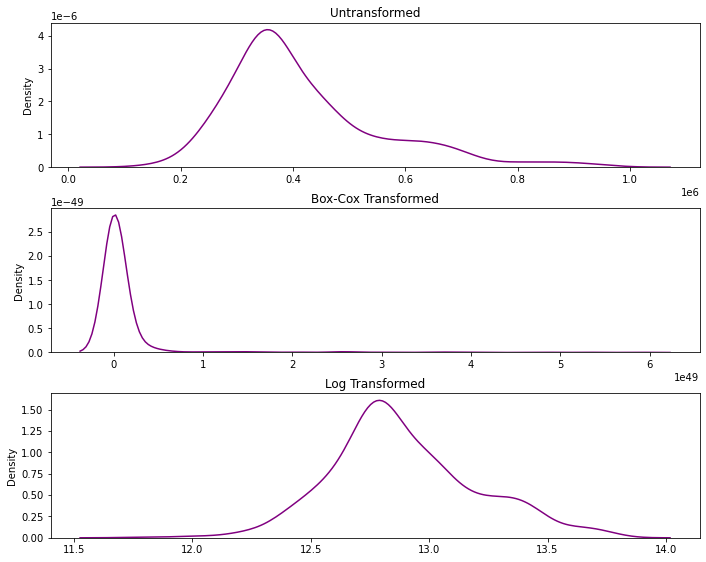

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 8))

fig.tight_layout(pad = 2)

#fig.suptitle('Median Income 2010', fontsize=12)

p1 = sns.kdeplot(data = df19['medianValue'], color = "purple", ax = ax[0])
p1.set(xlabel=None)
ax[0].set_title('Untransformed')

p2 = sns.kdeplot(data = hpb19, color = "purple", ax = ax[1])
p2.set(xlabel=None)
ax[1].set_title('Box-Cox Transformed')

p3 = sns.kdeplot(data = hpl19, color = "purple", ax = ax[2])
p3.set(xlabel=None)    
ax[2].set_title('Log Transformed')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/Home Price Transformation 2019.png', bbox_inches='tight')
plt.close()

print("Home Prices 2019 Exported")

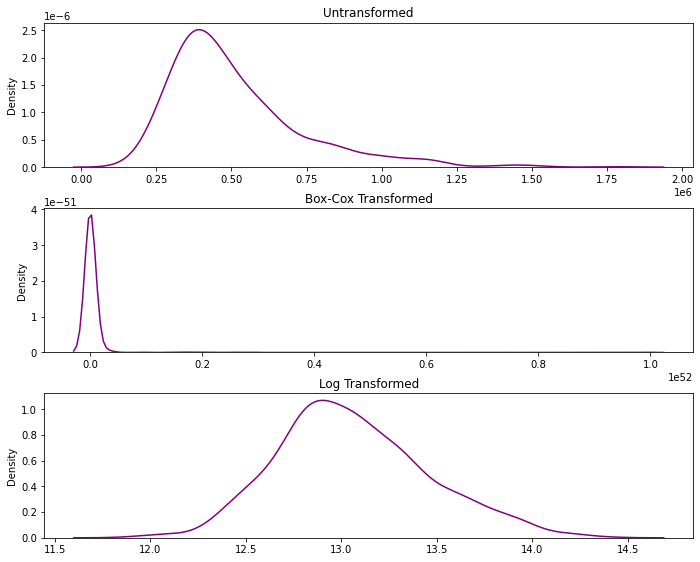

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 8))

fig.tight_layout(pad = 2)

#fig.suptitle('Median Income 2010', fontsize=12)

p1 = sns.kdeplot(data = df10['medianInc'], color = "purple", ax = ax[0])
p1.set(xlabel=None)
ax[0].set_title('Untransformed')

p2 = sns.kdeplot(data = hib10, color = "purple", ax = ax[1])
p2.set(xlabel=None)
ax[1].set_title('Box-Cox Transformed')

p3 = sns.kdeplot(data = hil10, color = "purple", ax = ax[2])
p3.set(xlabel=None)    
ax[2].set_title('Log Transformed')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/Median Income Transformation 2010.png', bbox_inches='tight')
plt.close()

print("Median Income 2010 Exported")

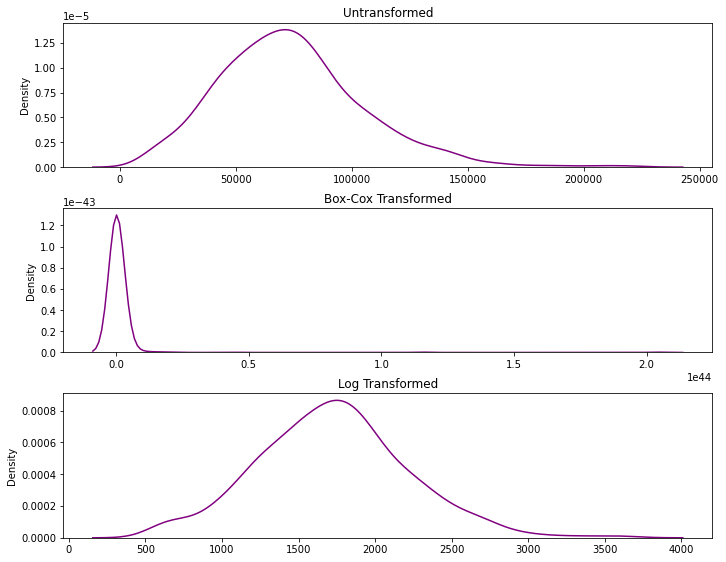

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 8))

fig.tight_layout(pad = 2)

#fig.suptitle('Median Income 2010', fontsize=12)

p1 = sns.kdeplot(data = df19['medianInc'], color = "purple", ax = ax[0])
p1.set(xlabel=None)
ax[0].set_title('Untransformed')

p2 = sns.kdeplot(data = hib19, color = "purple", ax = ax[1])
p2.set(xlabel=None)
ax[1].set_title('Box-Cox Transformed')

p3 = sns.kdeplot(data = hil19, color = "purple", ax = ax[2])
p3.set(xlabel=None)    
ax[2].set_title('Log Transformed')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/Median Income Transformation 2019.png', bbox_inches='tight')
plt.close()

print("Median Income 2019 Exported")

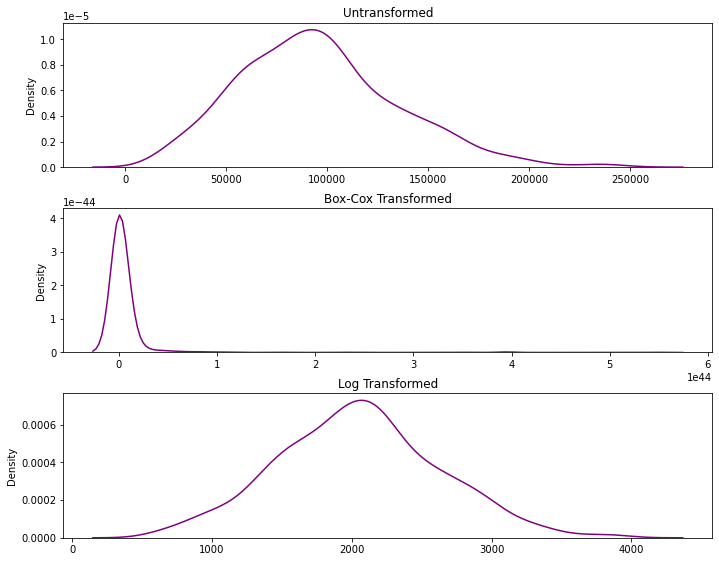

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 8))

fig.tight_layout(pad = 2)

#fig.suptitle('Contract Rent 2010', fontsize=12)

p1 = sns.kdeplot(data = df10['medianCR'], color = "purple", ax = ax[0])
p1.set(xlabel=None)
ax[0].set_title('Untransformed')

p2 = sns.kdeplot(data = crb10, color = "purple", ax = ax[1])
p2.set(xlabel=None)
ax[1].set_title('Box-Cox Transformed')

p3 = sns.kdeplot(data = crl10, color = "purple", ax = ax[2])
p3.set(xlabel=None)    
ax[2].set_title('Log Transformed')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/Contract Rent Transformation 2010.png', bbox_inches='tight')
plt.close()

print("Contract Rent 2010 Exported")

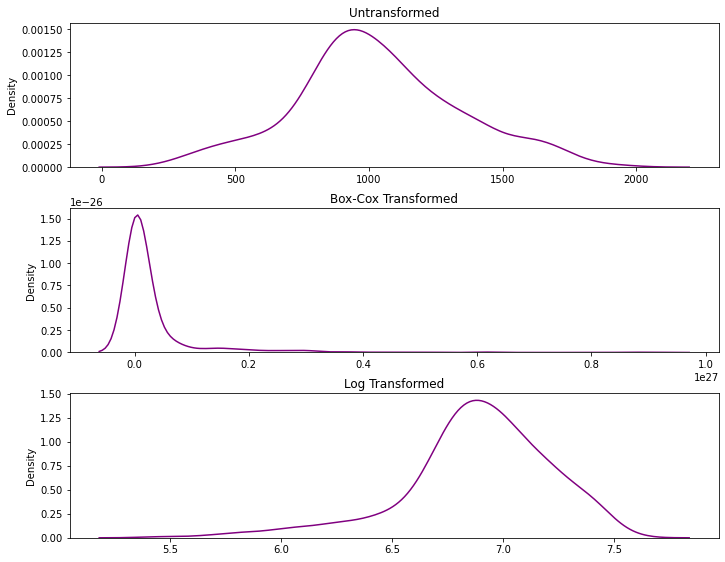

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 8))

fig.tight_layout(pad = 2)

#fig.suptitle('Contract Rent 2010', fontsize=12)

p1 = sns.kdeplot(data = df19['medianCR'], color = "purple", ax = ax[0])
p1.set(xlabel=None)
ax[0].set_title('Untransformed')

p2 = sns.kdeplot(data = crb19, color = "purple", ax = ax[1])
p2.set(xlabel=None)
ax[1].set_title('Box-Cox Transformed')

p3 = sns.kdeplot(data = crl19, color = "purple", ax = ax[2])
p3.set(xlabel=None)    
ax[2].set_title('Log Transformed')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/Contract Rent Transformation 2019.png', bbox_inches='tight')
plt.close()

print("Contract Rent 2019 Exported")

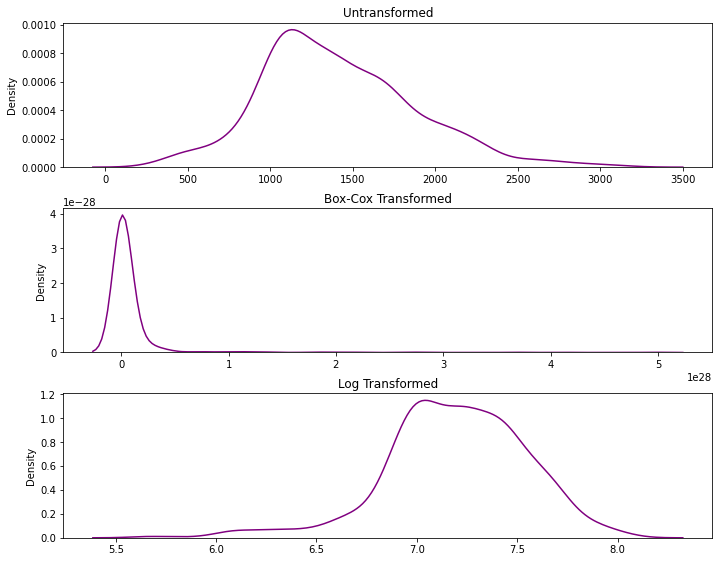

<h3>Calculate Occupation Share</h3>
<p>In the analysis we are only concerned with the top occupations. Therefore, we want to calculate the share of workers with the "top" occupations for each census tract.</p>

In [ ]:
#  Process occupational data
def process_occ_data(df):
    #  Columns of interest
    occ = ['top_occ','service','sales','nat_construction','production']
    
    occ_data = pd.DataFrame()
    
    # Add the 'knowledge worker' share -- this is columns 0-2 of the data frame
    occ_data['kw_pct'] = (df.loc[:,occ[0]] / df.loc[:,'total (occupation)'])*100
    
    return occ_data

occ10 = process_occ_data(df10) 
occ19 = process_occ_data(df19)  

In [ ]:
occ10.sample(3, random_state=r_state)

<h3>Calculate Education Share</h3>
<p>We are interested in the share of the population that has a bachelor's degree or higher which are the first four entries in the list of education levels.</p>

In [ ]:
#  Process occupational data
def process_edu_data(df):
    #  Columns of interest
    edu = ['doctorate','professional','masters','bachelors','highSchool', 'middleSchool', 'elementary', 'noSchool']
    
    edu_data = pd.DataFrame()
    
    edu_data['he_pct'] = (df.loc[:,edu[0:3]].sum(axis=1) / df.loc[:,'total (education)'])*100
    
    return edu_data

edu10 = process_edu_data(df10) 
edu19 = process_edu_data(df19)  

In [ ]:
edu10.sample(3, random_state=r_state)

<h2>PCA Using the Scoring Dataset</h2>
<p>Before doing any analysis it's important to clean the full dataset to ensure there are no null or infinite values in the dataset as PCA fails when such values exist.</p>
<p>Here I choose to use the Untransformed Data. Although the Box-Cox transformation had the highest explained variance, the untransformed data yielded the best results when running random forest regressions. Additionally, the Box-Cox transformation was quite skewed with extremely high outliers that I wished to avoid including in my final analysis.</p>

In [ ]:
# Don't forget to set the house price and income scores to the 
# transform/non-transform that you want to use!
to_use = 'Untransformed' # Choices: ['Untransformed','Box-Cox','Log']

In [ ]:
#  Indicators
edu_score_10 = process_edu_data(df10)  
occ_score_10 = process_occ_data(df10)    
edu_score_19 = process_edu_data(df19) 
occ_score_19 = process_occ_data(df19)   

house_pr_score_10 = None  
hh_inc_score_10 = None
cr_score_10 = None
house_pr_score_19 = None 
hh_inc_score_19 = None  
cr_score_19 = None

if to_use == 'Untransformed':
    house_pr_score_10 = df_transformed['hpu_10']  
    hh_inc_score_10 = df_transformed['hiu_10']
    cr_score_10 = df_transformed['cru_10']
    house_pr_score_19 = df_transformed['hpu_19']  
    hh_inc_score_19 = df_transformed['hiu_19']
    cr_score_19 = df_transformed['cru_19']
elif to_use == 'Box-Cox':
    house_pr_score_10 = df_transformed['hpb_10']  
    hh_inc_score_10 = df_transformed['hib_10']
    cr_score_10 = df_transformed['crb_10']
    house_pr_score_19 = df_transformed['hpb_19']  
    hh_inc_score_19 = df_transformed['hib_19']
    cr_score_19 = df_transformed['crb_19']
elif to_use == 'Log':
    house_pr_score_10 = df_transformed['hpl_10']  
    hh_inc_score_10 = df_transformed['hil_10']
    cr_score_10 = df_transformed['crl_10']
    house_pr_score_19 = df_transformed['hpl_19']  
    hh_inc_score_19 = df_transformed['hil_19']
    cr_score_19 = df_transformed['crl_19']

In [ ]:
checks = {
    "Education 2010":edu_score_10,
    "Education 2019":edu_score_19,
    "Occupations 2010":occ_score_10,
    "Occupations 2019":occ_score_19,
    "House Prices 2010":house_pr_score_10,
    "House Prices 2019":house_pr_score_19,
    "Incomes 2010":hh_inc_score_10,
    "Incomes 2019":hh_inc_score_19,
    "Contract Rent 2010":cr_score_10,
    "Contract Rent 2019":cr_score_19
}

for k, v in checks.items():
    if (np.isnan(v.values).any()):
        v.dropna(inplace = True)
        
for k, v in checks.items():
    if (np.isnan(v.values).any()):
        print("Have null values in data set: " + k)

In [ ]:
#  Create dataset of indicator data - 2010
res_10 = pd.concat([house_pr_score_10,edu_score_10,occ_score_10,hh_inc_score_10, cr_score_10], axis=1)
res_19 = pd.concat([house_pr_score_19,edu_score_19,occ_score_19,hh_inc_score_19, cr_score_19], axis=1)

res_10.dropna(inplace = True)
res_19.dropna(inplace = True)

if to_use == 'Untransformed':
    res_10.columns = ['House Prices 2010','Percentage with Bachelor Degree or Higher 2010',
                      'Percentage Professional Workers 2010','Household Income 2010', 
                     'Contract Rent 2010']
    res_19.columns = ['House Prices 2019','Percentage with Bachelor Degree or Higher 2019',
                      'Percentage Professional Workers 2019','Household Income 2019', 
                     'Contract Rent 2019']
else:
    res_10.columns = ['House Prices 2010 (' + to_use + ' Transformed)','Percentage with Bachelor Degree or Higher 2010',
                      'Percentage Professional Workers 2010','Household Income 2010 (' + to_use + ' Transformed)', 
                     'Contract Rent 2010 (' + to_use + 'Transformed)']
    res_19.columns = ['House Prices 2019 (' + to_use + ' Transformed)','Percentage with Bachelor Degree or Higher 2019',
                      'Percentage Professional Workers 2019','Household Income 2019 (' + to_use + ' Transformed)', 
                     'Contract Rent 2019 (' + to_use + 'Transformed)']

# Create dataset of indicator data
X_10 = res_10.values
X_19 = res_19.values

#  Join 2010 and 2019 datasets and sanity-check
SES_inds = np.concatenate((X_10, X_19), axis=0)

print("Any infinite values? " + str(~np.isfinite(SES_inds).any()))
print("Any NaN values? " + str(np.isnan(SES_inds).any()))

In [ ]:
#  Median removal and Unit scaling
scaler = preprocessing.RobustScaler()
scaler.fit(SES_inds)
SES_inds = scaler.transform(SES_inds)

print("Data scaled and transformed.")

In [ ]:
pca_full = decomposition.PCA()                           # Use all Principal Components
pca_full.fit(SES_inds)                                   # Train model on data
SES_full_T = pd.DataFrame(pca_full.transform(SES_inds))  # Transform data using model

print("The amount of explained variance of the SES score using each component is...")
print(pca_full.explained_variance_ratio_)


# Adapted from https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
#i = np.identity(SES_inds.shape[1])  # identity matrix

#coef = pca_full.transform(i)

coef = (pca_full.components_)

#loadings = pd.DataFrame(coef, index=res_10.columns)
#loadings.to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/pcaLoadings-' + to_use + '.csv', index=True)

<p><b>Results for the Untransformed Data: </b><br>
The amount of explained variance of the SES score using each component is...<br>
[0.72909837 0.11470007 0.07954741 0.06284945 0.0138047 ]</p>

<p><b>Results for the Box-Cox Transformed Data: </b><br>
The amount of explained variance of the SES score using each component is...<br>
[9.93855920e-01 4.87008283e-03 1.27224067e-03 1.65340276e-06 1.03174683e-07]</p>

<p><b>Results for the Log Transformed Data: </b><br>
The amount of explained variance of the SES score using each component is...<br>
[0.70797274 0.14330925 0.08178891 0.05088614 0.01604295]</p>

In [ ]:
#  Fitting PCA Model to derive SES score
pca = decomposition.PCA(n_components=1)             # Only need 1st Principal Component
pca.fit(SES_inds)                                   #  Train model on data
SES_inds_T = pd.DataFrame(pca.transform(SES_inds))  #  Transform data using model

print("The amount of explained variance of the SES score is: {0:6.5f}".format(pca.explained_variance_ratio_[0]))

In [ ]:
#loadings for the first component
print(pca.components_)

<p><b>Results for the Untransformed Data: </b><br>
The amount of explained variance of the SES score is: 0.72910</p>

<p><b>Results for the Box-Cox Transformed Data: </b><br>
The amount of explained variance of the SES score is: 0.99386</p>

<p><b>Results for the Log Transformed Data: </b><br>
The amount of explained variance of the SES score is: 0.70797</p>

<h3>Build the final SES Dataset</h3>
<p>Some geoids will contain missing SES values in either 2010 or 2019. This is because we had to drop null values in order to run the PCA. This means the 2010 and 2019 datasets are different sizes and therefore some contain data for geoids that the other does not.</p>

In [ ]:
#  Split transformed data into 2010 and 2019 datasets
#  Note the way we do this to deal with missing data (if any)
scores_10 = SES_inds_T.loc[0:len(X_10)-1,0]
scores_19 = SES_inds_T.loc[len(X_10):,0]

# Create dfs from the two sets of scores
res_10 = res_10.assign(scores=pd.Series(scores_10).values)
res_19 = res_19.assign(scores=pd.Series(scores_19).values)

# Join them together so we've got a single df for 2010 and 2019
res = res_10.merge(res_19, how='outer', suffixes=('_10','_19'), left_index=True, right_index=True)

# Rename columns 
res.rename(columns={'scores_10':'SES_10', 'scores_19':'SES_19'}, inplace=True)

# Sanity check
res.head(3)

In [ ]:
res.corr()

In [ ]:
# Create a Score dataset for Boston alone
bos_tracts = pd.read_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/Census_2010_Tracts.csv', index_col = 0)
bos_tracts.rename(columns = {'GEOID10':'geoid'}, inplace = True)

res_bos = pd.merge(res, bos_tracts, on='geoid', how='inner')

In [ ]:
#  Compute rank of geoid in 2010 (so low rank = 'low status')
res['RANK_10'] = res.SES_10.rank(ascending=False)
res_bos['RANK_10'] = res_bos.SES_10.rank(ascending=False)

#  Compute rank of geoid in 2019 (so low rank = 'low status')
res['RANK_19'] = res.SES_19.rank(ascending=False)
res_bos['RANK_19'] = res_bos.SES_19.rank(ascending=False)

#  Compute amount by geoid has ascended (so +ve = status improvement; -ve = status decline)
res.loc[:,'SES_ASC'] = res.loc[:,'SES_19'] - res.loc[:,'SES_10']
res_bos.loc[:,'SES_ASC'] = res_bos.loc[:,'SES_19'] - res_bos.loc[:,'SES_10']

In [ ]:
res.corr()

In [ ]:
import re 
#  Calculate geoid percentile score in 10
res.loc[:,'SES_PR_10'] = res.RANK_10.rank(ascending=False, pct=True) * 100
res_bos.loc[:,'SES_PR_10'] = res_bos.RANK_10.rank(ascending=False, pct=True) * 100

#  Calculate geoid percentile score in 19
res.loc[:,'SES_PR_19'] = res.RANK_19.rank(ascending=False, pct=True) * 100
res_bos.loc[:,'SES_PR_19'] = res_bos.RANK_19.rank(ascending=False, pct=True) * 100

#  Calculate percentile change (so +ve = 'moved up' in the world; -ve = 'moved down')
res.loc[:,'SES_PR_ASC'] = res.loc[:,'SES_PR_19'] - res.loc[:,'SES_PR_10']
res_bos.loc[:,'SES_PR_ASC'] = res_bos.loc[:,'SES_PR_19'] - res_bos.loc[:,'SES_PR_10']

inp = res.loc[:,[x for x in res.columns if 'SES' not in x and 'RANK' not in x]]
inp_bos = res_bos.loc[:,[x for x in res_bos.columns if 'SES' not in x and 'RANK' not in x]]

# Tidy up the naming
inp.rename(columns=lambda x: re.sub('_19',' 2019',re.sub('_10',' 2010',x)), inplace=True)
inp.rename(columns=lambda x: re.sub('kw_pct','Knowledge Worker Percentage',x), inplace=True)
inp.rename(columns=lambda x: re.sub('he_pct','Highly-Educated Percentage',x), inplace=True)
inp.rename(columns=lambda x: re.sub('hp','Property Prices (Transformed)',x), inplace=True)
inp.rename(columns=lambda x: re.sub('hi','Household Income (Transformed)',x), inplace=True)
inp.rename(columns=lambda x: re.sub('cr','Contract Rent (Transformed)',x), inplace=True)

inp_bos.rename(columns=lambda x: re.sub('_19',' 2019',re.sub('_10',' 2010',x)), inplace=True)
inp_bos.rename(columns=lambda x: re.sub('kw_pct','Knowledge Worker Percentage',x), inplace=True)
inp_bos.rename(columns=lambda x: re.sub('he_pct','Highly-Educated Percentage',x), inplace=True)
inp_bos.rename(columns=lambda x: re.sub('hp','Property Prices (Transformed)',x), inplace=True)
inp_bos.rename(columns=lambda x: re.sub('hi','Household Income (Transformed)',x), inplace=True)
inp_bos.rename(columns=lambda x: re.sub('cr','Contract Rent (Transformed)',x), inplace=True)

# Save to file (note that we are also saving some info about the input variables as we use these as well)
# res[
#     ['RANK_10','RANK_19','SES_10','SES_19','SES_ASC','SES_PR_10','SES_PR_19','SES_PR_ASC']
# ].to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/scores' + to_use + '.csv', index=True) 
# inp[
#     [x for x in inp.columns if '2010' in x]
# ].to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/inputs2010' + to_use + '.csv', index=True)
# inp[
#     [x for x in inp.columns if '2019' in x]
# ].to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/inputs2019' + to_use + '.csv', index=True)

# # Save Boston Files
# res_bos[
#     ['RANK_10','RANK_19','SES_10','SES_19','SES_ASC','SES_PR_10','SES_PR_19','SES_PR_ASC']
# ].to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/scores Boston' + to_use + '.csv', index=True) 
# inp_bos[
#     [x for x in inp.columns if '2010' in x]
# ].to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/inputs2010 Boston' + to_use + '.csv', index=True)
# inp_bos[
#     [x for x in inp.columns if '2019' in x]
# ].to_csv('/Users/ritalaplante/Desktop/Thesis Data and Analytics/04-Neighborhood Scores/inputs2019 Boston' + to_use + '.csv', index=True)

In [ ]:
#  Sanity check
res[['SES_10','SES_19','RANK_10','RANK_19','SES_PR_10','SES_PR_19','SES_PR_ASC']].sample(5, random_state=r_state)

<h2>Quick Summary of the Ranked Data</h2>

In [ ]:
# The lowest-ranked (highest status) geoids
res.loc[res['RANK_10'] < 5,:].sort_values('RANK_10')

In [ ]:
# The highest-ranked (lowest status) geoids
res.loc[res['RANK_10'] > (res.RANK_10.max()-5),:].sort_values('RANK_10')

In [ ]:
# Biggest falls in percentile status
res.sort_values('SES_PR_ASC').head(5)

In [ ]:
# Biggest gains in percentile status
res.sort_values('SES_PR_ASC', ascending=False).head(5)

In [ ]:
g = sns.jointplot(x='SES_10', y='SES_19', data=res, kind='scatter', s=3, color='k', height=7, ratio=5, space=0, linewidth=1)

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/SES Scatter.png', bbox_inches='tight')
plt.close()

print("Plot Exported.")

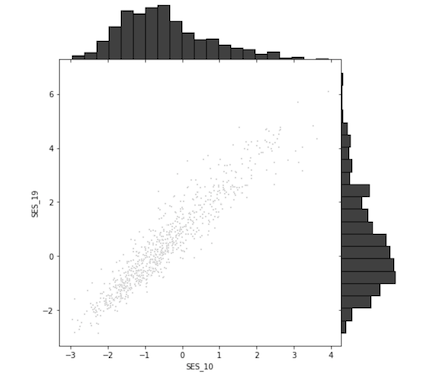

In [ ]:
g = sns.jointplot(x='SES_PR_10', y='SES_PR_19', data=res, kind='scatter', s=3, color='k')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/SES PR ASC Scatter.png', bbox_inches='tight')
plt.close()

print('Plot Exported.')

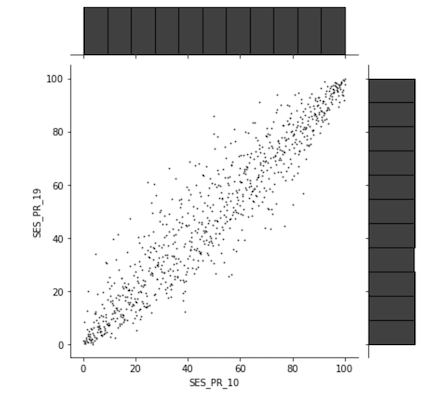

In [ ]:
g = sns.jointplot(x='RANK_10', y='RANK_19', data=res, kind='scatter', s=3, color='k')

fig = plt.gcf() # *G*et the *C*urrent *F*igure environment so that the next command works
plt.savefig('/Users/ritalaplante/Desktop/Thesis Data and Analytics/08-Plot Outputs/SES Rank Scatter.png', bbox_inches='tight')
plt.close()

print('Plot Exported.')

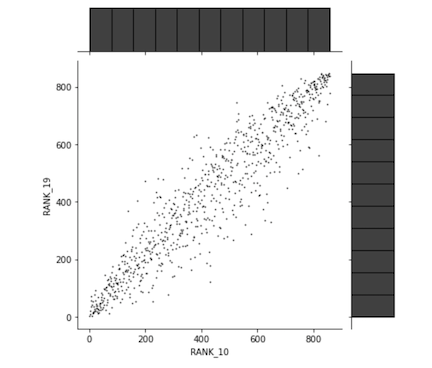